# CREACION DE DATASETS POR ESTACIONE

Dimensiones del DataFrame Gandia_2007: (11754, 10)
Dimensiones del DataFrame Gandia_2007: (7933, 8)
Dimensiones del DataFrame Gandia_2008: (7589, 11)
Dimensiones del DataFrame Gandia_2009: (16500, 10)
Dimensiones del DataFrame Gandia_2010: (11754, 10)
Dimensiones del DataFrame Gandia_2011: (1560, 19)
Dimensiones del DataFrame Gandia_2012: (8749, 10)
Dimensiones del DataFrame Gandia_2013: (8570, 7)
Dimensiones del DataFrame Gandia_2014: (8699, 7)
Dimensiones del DataFrame Gandia_2015: (8510, 7)
Dimensiones del DataFrame Gandia_2016: (8719, 7)
Dimensiones del DataFrame Gandia_2017: (8670, 7)
Dimensiones del DataFrame Gandia_2018: (8612, 7)
Dimensiones del DataFrame Gandia_2019: (8641, 7)
Dimensiones del DataFrame Gandia_2020: (8658, 7)
Dimensiones del DataFrame Gandia_2021: (8602, 7)
Dimensiones del DataFrame Gandia_2022: (8601, 7)
Dimensiones del DataFrame Gandia_2023: (8592, 7)
Dimensiones del DataFrame Gandia_2024: (8613, 7)
Dimensiones del DataFrame Gandia_2025: (8500, 7)
      SO2  

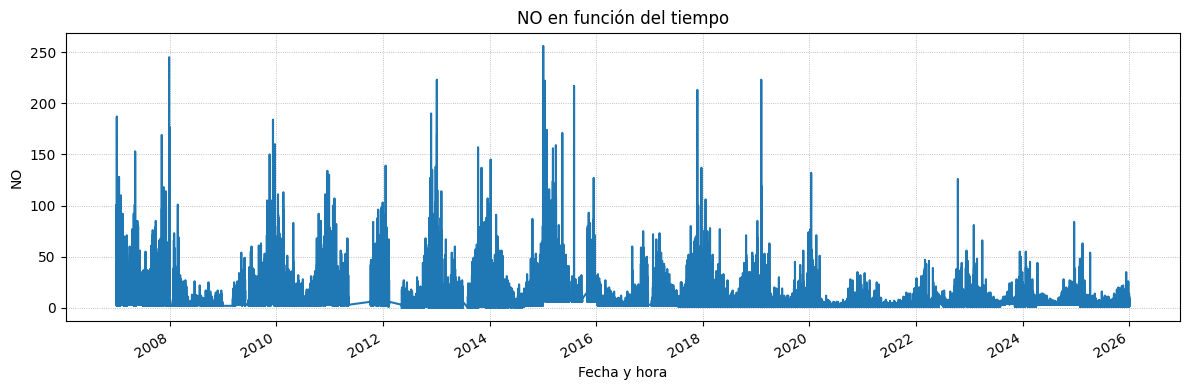

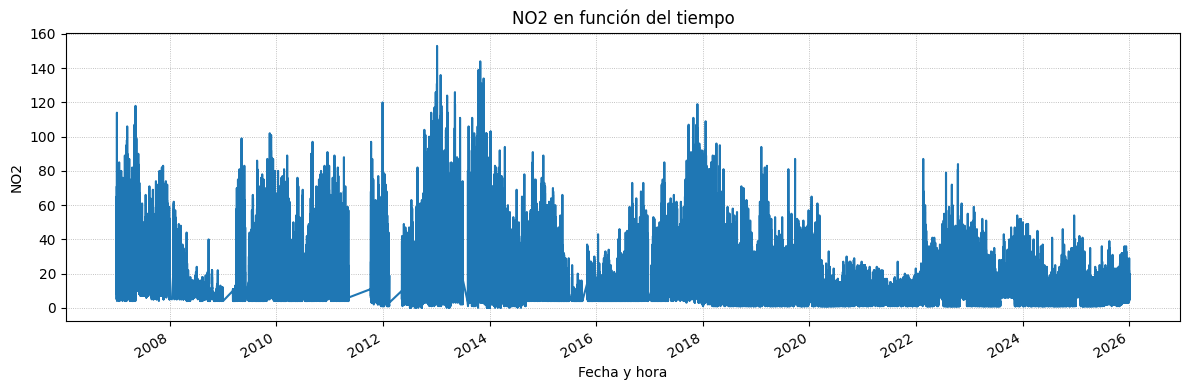

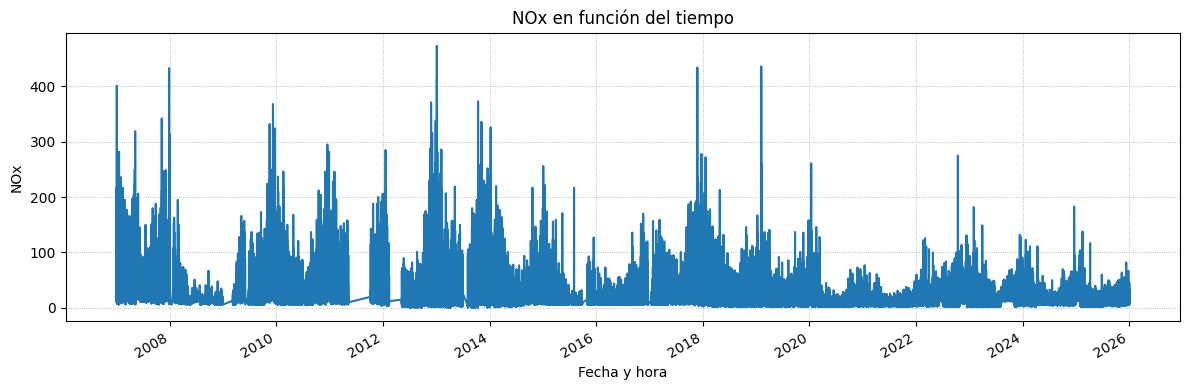

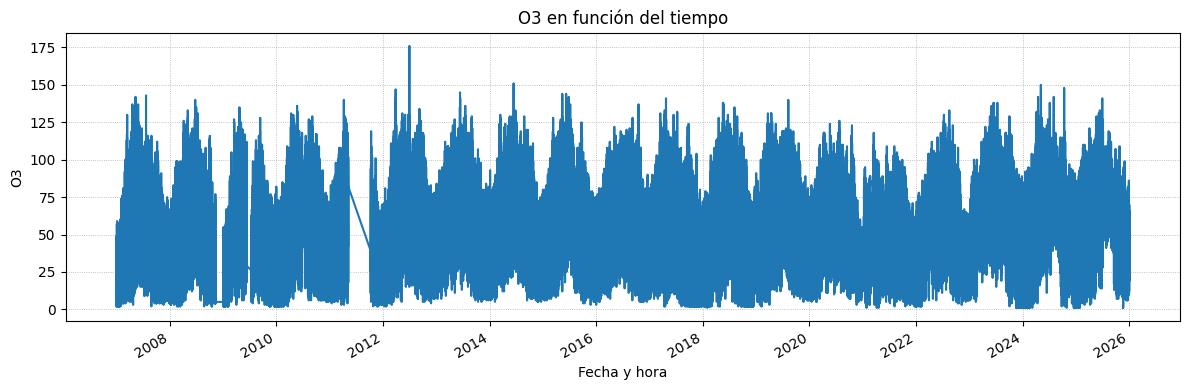

Información: no hay datos válidos para Veloc.. Se omite la gráfica.
Información: no hay datos válidos para Direc.. Se omite la gráfica.


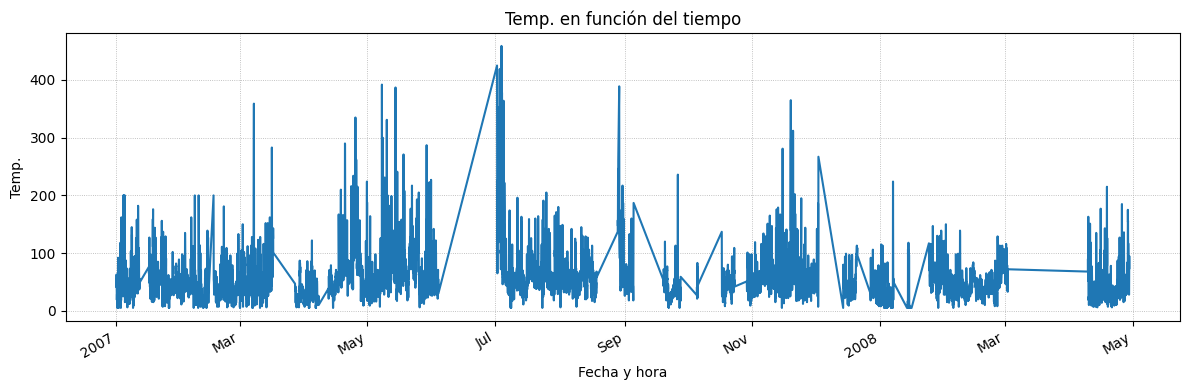

Información: no hay datos válidos para R.Sol.. Se omite la gráfica.
Información: no hay datos válidos para Pres.. Se omite la gráfica.


In [4]:
#Bibliotecas
import pandas as pd
import re

# 1.1 Estaciones Alicante

file_path_T3_Gandia = "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Gandia"


# Lectura del fichero de 2007
file_path_T3_Gandia_2007 = file_path_T3_Gandia + "/MHEST461310022010.txt"
df_Gandia_2007 = pd.read_csv(
    file_path_T3_Gandia_2007,
    sep="\t",
    encoding="latin-1",
    skiprows=3,
    na_values=["", "NA", "nan"],
    skipinitialspace=True,
    dtype=str  # leer inicialmente todo como texto para limpiar comas decimales
)

# Lectura inicial saltando las tres primeras líneas de metadatos ya que no contienen datos útiles, solo el nombre de la estación y su numero.
# La cabecera con los nombres de columna está en la cuarta línea del fichero

# Normalizar nombres de columnas
df_Gandia_2007.columns = df_Gandia_2007.columns.str.strip()

# El fichero contiene una fila con las unidades justo tras la cabecera
# Detectamos y eliminamos esa fila comprobando que FECHA tenga formato dd/mm/YYYY
if "FECHA" not in df_Gandia_2007.columns:
    raise ValueError("No se ha encontrado la columna FECHA en la cabecera. Verifique el archivo.")

# Crear máscara que identifica filas con fecha válida
mask_fecha_valida = df_Gandia_2007["FECHA"].astype(str).str.match(r"\d{2}/\d{2}/\d{4}")
# Filtrar solamente filas de datos
df_Gandia_2007 = df_Gandia_2007[mask_fecha_valida].copy()

# Normalizar la columna HORA y crear columna datetime
# Algunas horas vienen como '0' o '00' etc; se rellenan a dos dígitos y se añade minuto
df_Gandia_2007["HORA"] = df_Gandia_2007["HORA"].astype(str).str.zfill(2).str.replace(r"\.0+$", "", regex=True)
fecha_hora = df_Gandia_2007["FECHA"].astype(str).str.strip() + " " + df_Gandia_2007["HORA"].astype(str).str.strip() + ":00"
df_Gandia_2007["datetime"] = pd.to_datetime(fecha_hora, dayfirst=True, errors="coerce")

# Eliminar filas sin fecha válida tras el parseo
df_Gandia_2007 = df_Gandia_2007[~df_Gandia_2007["datetime"].isna()].copy()  
# Eliminar columnas originales FECHA y HORA
df_Gandia_2007 = df_Gandia_2007.drop(columns=["FECHA", "HORA"], errors="ignore")

# Conversión de columnas numéricas: reemRabassazar coma decimal por punto y coerción
for col in df_Gandia_2007.columns:
    if col == "datetime":
        continue
    # ReemRabassazar valores vacíos por NaN y comas por puntos
    df_Gandia_2007[col] = df_Gandia_2007[col].replace(["", " "], pd.NA)
    df_Gandia_2007[col] = df_Gandia_2007[col].astype(str).str.replace(",", ".", regex=False)
    df_Gandia_2007[col] = pd.to_numeric(df_Gandia_2007[col], errors="coerce")

# Ordenar por tiempo y reiniciar índice
df_Gandia_2007 = df_Gandia_2007.sort_values("datetime").reset_index(drop=True)
# Salida de verificación
print("Dimensiones del DataFrame Gandia_2007:", df_Gandia_2007.shape)

# Función auxiliar para asegurar columnas FECHA y HORA
def ensure_fecha_hora(df):
    """
    A partir de un DataFrame con cabeceras y formatos variables,
    intenta garantizar que el DataFrame resultante tenga dos columnas:
    FECHA y HORA. Opera por heurística en nombres de columnas y en
    el contenido de las mismas.
    """
    # Copia para no modificar accidentalmente fuera de la función
    df = df.copy()
    cols = list(df.columns)
    # Mapear nombres normalizados
    norm = {col: re.sub(r'\s+', ' ', str(col)).strip().upper() for col in cols}

    # Caso 1: existe una columna cuyo nombre contiene tanto FECHA como HORA
    combined_col = None
    for orig, up in norm.items():
        if 'FECHA' in up and 'HORA' in up:
            combined_col = orig
            break

    # Caso 2: detectar columnas separadas por nombre
    fecha_col = None
    hora_col = None
    for orig, up in norm.items():
        if 'FECHA' == up or up.startswith('FECHA ') or up.startswith('FECHA_') or up == 'DATE':
            fecha_col = orig
        if 'HORA' == up or up.startswith('HORA ') or up.startswith('HORA_') or up in ('TIME', 'HOUR'):
            hora_col = orig

    # Si hay ambas detectadas por nombre, renombrar y devolver
    if fecha_col and hora_col:
        df = df.rename(columns={fecha_col: 'FECHA', hora_col: 'HORA'})
        return df

    # Si la cabecera combinada existe, separar sus valores
    if combined_col:
        combined = df[combined_col].astype(str).str.strip()
        parts = combined.str.split(r'[\sT,;]+', n=1, expand=True)
        df['FECHA'] = parts[0]
        df['HORA'] = parts[1].fillna('')
        df = df.drop(columns=[combined_col])
        return df

    # Heurística por contenido
    date_regex = re.compile(r'\d{2}/\d{2}/\d{4}')
    time_regex = re.compile(r'^\s*\d{1,2}(:\d{2})?\s*$')

    # Buscar columna que contenga fecha en su contenido
    detected_fecha = None
    for col in cols:
        sample = df[col].astype(str).dropna().head(30)
        if sample.apply(lambda x: bool(date_regex.search(x))).sum() > 0:
            # si en las entradas también aparece hora, separar
            if sample.apply(lambda x: bool(re.search(r'\d{2}/\d{2}/\d{4}.*\d{1,2}', x))).sum() > 0:
                parts = df[col].astype(str).str.strip().str.split(r'[\sT,;]+', n=1, expand=True)
                df['FECHA'] = parts[0]
                df['HORA'] = parts[1].fillna('')
                df = df.drop(columns=[col])
                return df
            detected_fecha = col
            break

    # Buscar columna con formato hora
    detected_hora = None
    for col in cols:
        sample = df[col].astype(str).dropna().head(30)
        if sample.apply(lambda x: bool(time_regex.search(x))).sum() > 0:
            detected_hora = col
            break

    if detected_fecha and detected_hora:
        df = df.rename(columns={detected_fecha: 'FECHA', detected_hora: 'HORA'})
        return df

    if detected_fecha and not detected_hora:
        # intentar extraer hora si la columna de fecha contiene ambas cosas
        parts = df[detected_fecha].astype(str).str.strip().str.split(r'[\sT,;]+', n=1, expand=True)
        df['FECHA'] = parts[0]
        df['HORA'] = parts[1].fillna('')
        if detected_fecha != 'FECHA':
            df = df.drop(columns=[detected_fecha])
        return df

    # Intento final: intentar parsear cada columna como datetime
    for col in cols:
        parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
        if parsed.notna().sum() > 0:
            df['FECHA'] = parsed.dt.strftime('%d/%m/%Y')
            df['HORA'] = parsed.dt.strftime('%H:%M').where(parsed.notna(), pd.NA).astype(str).str.replace('00:00', '').replace('', pd.NA)
            if col != 'FECHA':
                df = df.drop(columns=[col])
            return df

    # Si no se detecta nada razonable, crear columnas vacías para que el flujo no rompa
    df['FECHA'] = pd.NA
    df['HORA'] = pd.NA
    return df

# Bucle para crear df_Gandia_2007 hasta df_Gandia_2025
for year in range(2007, 2026):  # incluye 2007 hasta 2025
    file_path_Gandia_year = file_path_T3_Gandia + f"/MHEST46131002{year}.txt"

    df = pd.read_csv(
        file_path_Gandia_year,
        sep="\t",
        encoding="latin-1",
        skiprows=3,
        na_values=["", "NA", "nan"],
        skipinitialspace=True,
        dtype=str
    )

    # Asegurar que existan las columnas FECHA y HORA independientemente del nombre original
    df = ensure_fecha_hora(df)

    # Normalizar nombres de columnas
    df.columns = df.columns.str.strip()

    # Verificación de la columna FECHA
    if "FECHA" not in df.columns:
        raise ValueError(f"No se ha encontrado la columna FECHA en la cabecera del archivo {file_path_Gandia_year}. Verifique el archivo.")

    # Máscara para filas con fecha en formato dd/mm/YYYY
    mask_fecha_valida = df["FECHA"].astype(str).str.match(r"\d{2}/\d{2}/\d{4}")
    df = df[mask_fecha_valida].copy()

    # Normalizar HORA y crear columna datetime
    df["HORA"] = df["HORA"].astype(str).str.zfill(2).str.replace(r"\.0+$", "", regex=True)
    fecha_hora = df["FECHA"].astype(str).str.strip() + " " + df["HORA"].astype(str).str.strip() + ":00"
    df["datetime"] = pd.to_datetime(fecha_hora, dayfirst=True, errors="coerce")

    # Eliminar filas sin fecha válida tras el parseo
    df = df[~df["datetime"].isna()].copy()

    # Eliminar columnas originales FECHA y HORA
    df = df.drop(columns=["FECHA", "HORA"], errors="ignore")

    # Conversión de columnas numéricas: reemRabassazo de coma por punto y coerción a numérico
    for col in df.columns:
        if col == "datetime":
            continue
        df[col] = df[col].replace(["", " "], pd.NA)
        df[col] = df[col].astype(str).str.replace(",", ".", regex=False)
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Ordenar por tiempo y reiniciar índice
    df = df.sort_values("datetime").reset_index(drop=True)

    # Asignar a variable global con el nombre solicitado
    globals()[f"df_Gandia_{year}"] = df

    # Salida de verificación
    print(f"Dimensiones del DataFrame Gandia_{year}: {df.shape}")












print(df_Gandia_2007)














import pandas as pd
import re

# Años a unir
years = range(2007, 2026)  # incluye 2007 y 2015

# Columnas objetivo en el orden solicitado
target_cols = ["datetime", "NO", "NO2", "NOx", "O3", "Veloc.", "Direc.", "Temp.", "R.Sol.", "Pres."]

def _remove_accents(text):
    """Quita acentos básicos para facilitar la comparación."""
    text = str(text)
    replacements = {
        "á":"a", "Á":"A", "é":"e", "É":"E", "í":"i", "Í":"I",
        "ó":"o", "Ó":"O", "ú":"u", "Ú":"U", "ñ":"n", "Ñ":"N"
    }
    for k, v in replacements.items():
        text = text.replace(k, v)
    return text

def _normalize(colname):
    """Normaliza un nombre de columna para emparejamiento."""
    s = _remove_accents(colname).lower()
    # conservar solo letras y dígitos para comparar
    s = re.sub(r'[^a-z0-9]', '', s)
    return s

# Reglas de coincidencia por columna objetivo: listas de fragmentos probables
candidates = {
    "NO":     ["no", "oxn"],        # oxn es improbable pero se incluye por seguridad
    "NO2":    ["no2", "no_2", "noii"],
    "NOx":    ["nox", "noxx"],
    "O3":     ["o3", "ozono", "ozone"],
    "Veloc.": ["veloc", "velocidad", "vel"],
    "Direc.": ["direc", "direccion", "dir"],
    "Temp.":  ["temp", "temperatura", "t"],
    "R.Sol.": ["rsol", "radsol", "radsolar", "radiacion", "irr", "rs"],
    "Pres.":  ["pres", "presion", "pressure"]
    
}

def _find_best_match(norm_cols, fragment_list):
    """
    Busca la primera columna normalizada que contenga alguno de los fragmentos.
    norm_cols es dict map norm_name -> original_name
    fragment_list es lista de fragmentos de búsqueda ordenada por preferencia
    """
    for frag in fragment_list:
        for norm, orig in norm_cols.items():
            if frag in norm:
                return orig
    return None

# Acumular dataframes normalizados
dfs_to_concat = []

for year in years:
    varname = f"df_Gandia_{year}"
    if varname not in globals():
        print(f"Advertencia: no existe la variable {varname}, se omite el año {year}.")
        continue

    df_orig = globals()[varname].copy()

    # Asegurar columna datetime
    if "datetime" not in df_orig.columns:
        # Intentar crear datetime desde FECHA y HORA si existen
        if "FECHA" in df_orig.columns and "HORA" in df_orig.columns:
            fh = df_orig["FECHA"].astype(str).str.strip() + " " + df_orig["HORA"].astype(str).str.strip()
            df_orig["datetime"] = pd.to_datetime(fh, dayfirst=True, errors="coerce")
        else:
            # Intentar detectar una columna con valores fecha u datetime
            created = False
            for col in df_orig.columns:
                parsed = pd.to_datetime(df_orig[col], dayfirst=True, errors="coerce")
                if parsed.notna().sum() > 0:
                    df_orig["datetime"] = parsed
                    created = True
                    break
            if not created:
                # No se pudo crear datetime, añadir columna vacía para que el flujo no rompa
                df_orig["datetime"] = pd.NaT
                print(f"Advertencia: no se encontró columna datetime en {varname} y no se pudo inferirla. Se añadirá columna vacía.")

    # Construir mapa de nombres normalizados
    norm_map = { _normalize(c): c for c in df_orig.columns }

    # Preparar DataFrame con las columnas objetivo
    new_df = pd.DataFrame()
    new_df["datetime"] = df_orig["datetime"].copy()

    # Para cada columna objetivo buscar la mejor coincidencia y copiar o rellenar con NaN
    for tgt in target_cols:
        if tgt == "datetime":
            continue
        match = None
        # usar las reglas de candidates si existen
        if tgt in candidates:
            match = _find_best_match(norm_map, candidates[tgt])
        # si no se encontró con la heurística, intentar coincidencia exacta por normalización
        if match is None:
            # buscar columna cuyo nombre normalizado sea igual a la normalización de la etiqueta objetivo
            norm_tgt = _normalize(tgt)
            if norm_tgt in norm_map:
                match = norm_map[norm_tgt]
        # si se encontró, copiar y convertir a numérico
        if match is not None:
            series = df_orig[match].copy()
            # limpiar comas decimales si es texto y convertir
            series = series.replace(["", " "], pd.NA)
            series = series.astype(str).str.replace(",", ".", regex=False)
            series = pd.to_numeric(series, errors="coerce")
            new_df[tgt] = series
        else:
            # columna no encontrada en este año, crear con NaN
            new_df[tgt] = pd.NA
            print(f"Información: en {varname} no se encontró columna correspondiente a {tgt}. Se rellenará con valores nulos.")

    # Mantener solo filas con datetime válido
    if "datetime" in new_df.columns:
        new_df = new_df[~new_df["datetime"].isna()].copy()

    # Añadir columna de año por trazabilidad opcional
    new_df["year_source"] = year

    dfs_to_concat.append(new_df)

# Concatenar todos los dataframes
if dfs_to_concat:
    df_Gandia_completo = pd.concat(dfs_to_concat, ignore_index=True, sort=False)

    # Ordenar por datetime de más reciente a más antiguo
    df_Gandia_completo = df_Gandia_completo.sort_values("datetime", ascending=False).reset_index(drop=True)

    # Reordenar columnas al formato final solicitado
    cols_final = ["datetime", "NO", "NO2", "NOx", "O3", "Veloc.", "Direc.", "Temp.", "R.Sol.", "Pres.", "year_source"]
    # Asegurar que existen todas las columnas en el DataFrame final
    cols_present = [c for c in cols_final if c in df_Gandia_completo.columns]
    df_Gandia_completo = df_Gandia_completo[cols_present]

    print("DataFrame completo creado: df_Gandia_completo")
    print("Dimensiones:", df_Gandia_completo.shape)
else:
    df_Gandia_completo = pd.DataFrame(columns=target_cols + ["year_source"])
    print("No se encontraron dataframes para concatenar en los años indicados.")








print(df_Gandia_completo)









import os
from pathlib import Path
import pandas as pd

# Verificar existencia del DataFrame
if 'df_Gandia_completo' not in globals():
    raise RuntimeError("No existe el DataFrame df_Gandia_completo en el espacio de trabajo.")

# Trabajar sobre una copia para no alterar el original
df = df_Gandia_completo.copy()

# Normalizar la columna datetime a texto en formato legible
if "datetime" in df.columns:
    # Intentar convertir a datetime y luego formatear
    df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")
    # Formato sin guiones para evitar el caracte r menos en la salida
    df["datetime"] = df["datetime"].dt.strftime("%Y_%m_%d %H:%M:%S")

# Determinar ruta al Escritorio del usuario en macOS
desktop_path = Path.home() / "Desktop"
desktop_path.mkdir(parents=True, exist_ok=True)

# Nombre de archivo
output_path = desktop_path / "df_Gandia_completo.csv"

# Guardar CSV con codificación UTF 8 y sin índice
df.to_csv(output_path, index=False, encoding="utf-8")

# Informe de confirmación
filesize = output_path.stat().st_size if output_path.exists() else None
print(f"CSV guardado en: {output_path}")
print(f"Filas: {len(df)}  Columnas: {len(df.columns)}  Tamaño bytes: {filesize}")














import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Columnas a graficar en el orden solicitado
cols_to_plot = ["NO", "NO2", "NOx", "O3", "Veloc.", "Direc.", "Temp.", "R.Sol.", "Pres."]

# Comprobar que df_Gandia_completo existe
if 'df_Gandia_completo' not in globals():
    raise RuntimeError("No existe el DataFrame df_Gandia_completo en el espacio de trabajo.")

df_final = df_Gandia_completo.copy()

# Asegurar tipo datetime
if df_final["datetime"].dtype == object:
    df_final["datetime"] = pd.to_datetime(df_final["datetime"], errors="coerce", dayfirst=True)

# Eliminar filas sin datetime válido
df_final = df_final[~df_final["datetime"].isna()].copy()

# Para visualización ordenamos ascendentemente en el tiempo
df_final = df_final.sort_values("datetime").reset_index(drop=True)

# Formateador de fechas para eje x
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

# Generar una figura por variable. Cada figura es independiente
for col in cols_to_plot:
    if col not in df_final.columns:
        print(f"Advertencia: la columna {col} no está presente en df_Gandia_completo. Se omite.")
        continue

    series = df_final[["datetime", col]].dropna(subset=[col]).copy()

    if series.empty:
        print(f"Información: no hay datos válidos para {col}. Se omite la gráfica.")
        continue

    # Si la variable es numérica en texto con comas, intentar conversión
    if not pd.api.types.is_numeric_dtype(series[col]):
        series[col] = series[col].astype(str).str.replace(",", ".", regex=False)
        series[col] = pd.to_numeric(series[col], errors="coerce")
        series = series[~series[col].isna()]

    if series.empty:
        print(f"Información: tras conversión no quedan datos numéricos para {col}. Se omite la gráfica.")
        continue

    plt.figure(figsize=(12, 4))
    plt.plot(series["datetime"], series[col])
    plt.title(f"{col} en función del tiempo", fontsize=12)
    plt.xlabel("Fecha y hora", fontsize=10)
    plt.ylabel(col, fontsize=10)
    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, linestyle=":", linewidth=0.6)
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

    # Opcional: guardar la figura en archivo PNG
    # plt.savefig(f"grafica_{col}.png", dpi=150, bbox_inches="tight")
    # plt.close()


In [9]:
import re
import pandas as pd
from pathlib import Path
import glob
import os

def _remove_accents(text):
    text = str(text)
    replacements = {
        "á":"a", "Á":"A", "é":"e", "É":"E", "í":"i", "Í":"I",
        "ó":"o", "Ó":"O", "ú":"u", "Ú":"U", "ñ":"n", "Ñ":"N"
    }
    for k, v in replacements.items():
        text = text.replace(k, v)
    return text

def _normalize(colname):
    s = _remove_accents(colname).lower()
    s = re.sub(r'[^a-z0-9]', '', s)
    return s

def ensure_fecha_hora(df):
    df = df.copy()
    cols = list(df.columns)
    norm = {col: re.sub(r'\s+', ' ', str(col)).strip().upper() for col in cols}

    combined_col = None
    for orig, up in norm.items():
        if 'FECHA' in up and 'HORA' in up:
            combined_col = orig
            break

    fecha_col = None
    hora_col = None
    for orig, up in norm.items():
        if up == 'FECHA' or up.startswith('FECHA ') or up.startswith('FECHA_') or up == 'DATE':
            fecha_col = orig
        if up == 'HORA' or up.startswith('HORA ') or up.startswith('HORA_') or up in ('TIME', 'HOUR'):
            hora_col = orig

    if fecha_col and hora_col:
        df = df.rename(columns={fecha_col: 'FECHA', hora_col: 'HORA'})
        return df

    if combined_col:
        combined = df[combined_col].astype(str).str.strip()
        parts = combined.str.split(r'[\sT,;]+', n=1, expand=True)
        df['FECHA'] = parts[0]
        df['HORA'] = parts[1].fillna('')
        df = df.drop(columns=[combined_col])
        return df

    date_regex = re.compile(r'\d{2}/\d{2}/\d{4}')
    time_regex = re.compile(r'^\s*\d{1,2}(:\d{2})?\s*$')

    detected_fecha = None
    for col in cols:
        sample = df[col].astype(str).dropna().head(30)
        if sample.apply(lambda x: bool(date_regex.search(x))).sum() > 0:
            if sample.apply(lambda x: bool(re.search(r'\d{2}/\d{2}/\d{4}.*\d{1,2}', x))).sum() > 0:
                parts = df[col].astype(str).str.strip().str.split(r'[\sT,;]+', n=1, expand=True)
                df['FECHA'] = parts[0]
                df['HORA'] = parts[1].fillna('')
                df = df.drop(columns=[col])
                return df
            detected_fecha = col
            break

    detected_hora = None
    for col in cols:
        sample = df[col].astype(str).dropna().head(30)
        if sample.apply(lambda x: bool(time_regex.search(x))).sum() > 0:
            detected_hora = col
            break

    if detected_fecha and detected_hora:
        df = df.rename(columns={detected_fecha: 'FECHA', detected_hora: 'HORA'})
        return df

    if detected_fecha and not detected_hora:
        parts = df[detected_fecha].astype(str).str.strip().str.split(r'[\sT,;]+', n=1, expand=True)
        df['FECHA'] = parts[0]
        df['HORA'] = parts[1].fillna('')
        if detected_fecha != 'FECHA':
            df = df.drop(columns=[detected_fecha])
        return df

    for col in cols:
        parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
        if parsed.notna().sum() > 0:
            df['FECHA'] = parsed.dt.strftime('%d/%m/%Y')
            df['HORA'] = parsed.dt.strftime('%H:%M').where(parsed.notna(), pd.NA).astype(str)
            if col != 'FECHA':
                df = df.drop(columns=[col])
            return df

    df['FECHA'] = pd.NA
    df['HORA'] = pd.NA
    return df

def process_single_year_file(file_path):
    try:
        df = pd.read_csv(
            file_path,
            sep="\t",
            encoding="latin-1",
            skiprows=3,
            na_values=["", "NA", "nan"],
            skipinitialspace=True,
            dtype=str
        )
    except Exception as e:
        print(f"Error lectura archivo {file_path}:", e)
        return None

    df = ensure_fecha_hora(df)
    df.columns = df.columns.str.strip()

    if "FECHA" not in df.columns:
        print(f"Advertencia: FECHA no encontrada en {file_path}. Se omite fichero.")
        return None

    mask_fecha_valida = df["FECHA"].astype(str).str.match(r"\d{2}/\d{2}/\d{4}")
    df = df[mask_fecha_valida].copy()
    if df.empty:
        return None

    df["HORA"] = df["HORA"].astype(str).str.zfill(2).str.replace(r"\.0+$", "", regex=True)
    fecha_hora = df["FECHA"].astype(str).str.strip() + " " + df["HORA"].astype(str).str.strip() + ":00"
    df["datetime"] = pd.to_datetime(fecha_hora, dayfirst=True, errors="coerce")
    df = df[~df["datetime"].isna()].copy()
    if df.empty:
        return None

    df = df.drop(columns=["FECHA", "HORA"], errors="ignore")

    for col in df.columns:
        if col == "datetime":
            continue
        df[col] = df[col].replace(["", " "], pd.NA)
        df[col] = df[col].astype(str).str.replace(",", ".", regex=False)
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.sort_values("datetime").reset_index(drop=True)
    return df

def process_folder_and_save_csv(folder_path,
                                years=range(2004, 2026),
                                filename_prefix="df_",
                                output_dir=None,
                                pattern_base="MHEST*{}*.txt"):
    folder = Path(folder_path)
    if not folder.exists():
        print(f"No existe la carpeta {folder_path}. Se omite.")
        return None

    if output_dir is None:
        output_dir = Path.home() / "Desktop"
    else:
        output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    dfs = []
    for year in years:
        pattern = pattern_base.format(year)
        found = list(folder.glob(pattern))
        if not found:
            found = list(folder.glob(f"*{year}.txt"))

        if not found:
            print(f"Aviso: no se encontró archivo para el año {year} en {folder_path}")
            continue

        for fp in found:
            dfp = process_single_year_file(fp)
            if dfp is not None:
                dfp["year_source"] = int(year)
                dfs.append(dfp)

    if not dfs:
        print(f"No se han procesado datos válidos en {folder_path}.")
        return None

    df_complete = pd.concat(dfs, ignore_index=True, sort=False)
    df_complete = df_complete.sort_values("datetime", ascending=False).reset_index(drop=True)

    target_cols = ["datetime", "NO", "NO2", "NOx", "O3", "Veloc.", "Direc.", "Temp.", "R.Sol.", "year_source"]
    cols_present = [c for c in target_cols if c in df_complete.columns]
    df_complete = df_complete[cols_present]

    safe_name = re.sub(r'[^a-zA-Z0-9_]', '_', folder.name)
    out_file = output_dir / f"{filename_prefix}_{safe_name}_completo.csv"

    df_complete.to_csv(out_file, index=False, encoding="utf-8")
    print(f"CSV guardado en: {out_file}  Filas: {len(df_complete)} Columnas: {len(df_complete.columns)}")
    return out_file

# Lista de carpetas a procesar
list_of_folders = [
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Babel",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Pla",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Rabassa",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/El_Pinos",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Elda",

    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 2/Elxe/Elxe_agroalimentari",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 2/Elxe/Elxe_bomberos",

    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Gandia",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Beniganim",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Ontinyent",

    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Av_Francia",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_B_Sur",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Burjasot",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Moli",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Politecnic",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Quart_Poblet",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Silla",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Vivers",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Caudete_Fuentes",

    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Paterna",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Torrebaja",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villamarxant",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villar_Arzobispo",

    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Sagunto/S_CEA",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Sagunto/S_Nord",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Sagunto/S_Port",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Albalat_Taronjers",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Algar_Palancia",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Viver",

    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Burriana",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Almassora",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Ermita",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Grau",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Patronat",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Penyeta",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Cirat",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Onda",

    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 8/Alcora",
    
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 9/Coratxa",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 9/Morella",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 9/Sant_Jordi",
    "/Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 9/Zorita"
    
    # añade aquí más rutas a carpetas con los txt si las hay
]

# Salvar en el Escritorio del usuario
output_folder = Path.home() / "Desktop"

# Procesar cada carpeta y generar un CSV por carpeta, años 2006 a 2025
for folder in list_of_folders:
    process_folder_and_save_csv(folder_path=folder, years=range(2004, 2026), output_dir=output_folder)


Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Babel
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Babel
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Babel
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Babel
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Babel
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Alacant/Alacant_Babel
CSV guardado en: /Users/benjamincarbonell/Desktop/df__Alacant_Babel_completo.csv  Filas: 134778 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transect

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)


CSV guardado en: /Users/benjamincarbonell/Desktop/df__Alacant_Rabassa_completo.csv  Filas: 138279 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/El_Pinos
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/El_Pinos
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/El_Pinos
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/El_Pinos
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/El_Pinos
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/El_Pinos


/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)


CSV guardado en: /Users/benjamincarbonell/Desktop/df__El_Pinos_completo.csv  Filas: 133238 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Elda
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Elda
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Elda
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Elda
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Elda
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 1/Elda
CSV guardado en: /Users/benjamincarbonell/Desktop/df__Elda_completo.csv  Filas: 133989 Columnas: 7
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 2/Elxe

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

CSV guardado en: /Users/benjamincarbonell/Desktop/df__Elxe_bomberos_completo.csv  Filas: 141242 Columnas: 6
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Gandia
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Gandia
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Gandia
CSV guardado en: /Users/benjamincarbonell/Desktop/df__Gandia_completo.csv  Filas: 166072 Columnas: 6
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Beniganim
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Beniganim
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Beniganim


/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)


CSV guardado en: /Users/benjamincarbonell/Desktop/df__Beniganim_completo.csv  Filas: 165540 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Ontinyent
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Ontinyent
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 3/Ontinyent
CSV guardado en: /Users/benjamincarbonell/Desktop/df__Ontinyent_completo.csv  Filas: 160530 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Av_Francia
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Av_Francia
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Av_Francia
Aviso: no se encontró archivo para el añ

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

CSV guardado en: /Users/benjamincarbonell/Desktop/df__V_Av_Francia_completo.csv  Filas: 134966 Columnas: 8
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_B_Sur
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_B_Sur
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_B_Sur
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_B_Sur
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_B_Sur
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_B_Sur


/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)


CSV guardado en: /Users/benjamincarbonell/Desktop/df__V_B_Sur_completo.csv  Filas: 130584 Columnas: 6
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Burjasot
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Burjasot
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Burjasot
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Burjasot
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Burjasot
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Burjasot
CSV guardado en: /Users/benjamincarbonell/Desktop/df__V_Burjasot_completo.csv  Filas: 134661 Columnas: 10
Aviso: no se encon

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)


CSV guardado en: /Users/benjamincarbonell/Desktop/df__V_Politecnic_completo.csv  Filas: 141545 Columnas: 6
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Quart_Poblet
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Quart_Poblet
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Quart_Poblet
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Quart_Poblet
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Quart_Poblet
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Quart_Poblet
CSV guardado en: /Users/benjamincarbonell/Desktop/df__V_Quart_Poblet_completo.csv  Filas: 13439

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

CSV guardado en: /Users/benjamincarbonell/Desktop/df__V_Silla_completo.csv  Filas: 135426 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Vivers
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Vivers
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Vivers
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Vivers
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Vivers
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Valencia/V_Vivers


/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)


CSV guardado en: /Users/benjamincarbonell/Desktop/df__V_Vivers_completo.csv  Filas: 142062 Columnas: 6
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Caudete_Fuentes
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Caudete_Fuentes
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Caudete_Fuentes
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Caudete_Fuentes
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Caudete_Fuentes
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 4/Caudete_Fuentes
CSV guardado en: /Users/benjamincarbonell/Desktop/df__Caudete_Fuentes_completo.csv  Filas: 133432 Columnas: 6
Aviso: no se encontró archivo para el

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

CSV guardado en: /Users/benjamincarbonell/Desktop/df__Torrebaja_completo.csv  Filas: 116619 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villamarxant
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villamarxant
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villamarxant
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villamarxant
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villamarxant
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villamarxant
Aviso: no se encontró archivo para el año 2010 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villamarxant
Aviso: no se encontró archivo para el año

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)


CSV guardado en: /Users/benjamincarbonell/Desktop/df__Villamarxant_completo.csv  Filas: 120254 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villar_Arzobispo
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villar_Arzobispo
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villar_Arzobispo
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villar_Arzobispo
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villar_Arzobispo
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villar_Arzobispo
Aviso: no se encontró archivo para el año 2010 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 5/Villar_Arzobispo
Aviso: no 

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

CSV guardado en: /Users/benjamincarbonell/Desktop/df__S_Port_completo.csv  Filas: 122100 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Albalat_Taronjers
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Albalat_Taronjers
Aviso: no se encontró archivo para el año 2006 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Albalat_Taronjers
Aviso: no se encontró archivo para el año 2007 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Albalat_Taronjers
Aviso: no se encontró archivo para el año 2008 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Albalat_Taronjers
Aviso: no se encontró archivo para el año 2009 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Albalat_Taronjers
Aviso: no se encontró archivo para el año 2010 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 6/Albalat_Taronjers
Aviso: no

/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

CSV guardado en: /Users/benjamincarbonell/Desktop/df__C_Almassora_completo.csv  Filas: 338658 Columnas: 8
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Ermita
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Ermita


/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce'

CSV guardado en: /Users/benjamincarbonell/Desktop/df__C_Ermita_completo.csv  Filas: 174604 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Grau
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Grau


/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce'

CSV guardado en: /Users/benjamincarbonell/Desktop/df__C_Grau_completo.csv  Filas: 175664 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Patronat
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Patronat


/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(["", " "], pd.NA)
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:140: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

CSV guardado en: /Users/benjamincarbonell/Desktop/df__C_Patronat_completo.csv  Filas: 172507 Columnas: 7
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Penyeta
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Castellon/C_Penyeta


/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
/var/folders/85/2m2sr7rx6g5d561zn04dcq000000gn/T/ipykernel_56421/3191955429.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], dayfirst=True, errors='coerce'

CSV guardado en: /Users/benjamincarbonell/Desktop/df__C_Penyeta_completo.csv  Filas: 175630 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Cirat
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Cirat
CSV guardado en: /Users/benjamincarbonell/Desktop/df__Cirat_completo.csv  Filas: 181992 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Onda
Aviso: no se encontró archivo para el año 2005 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 7/Onda
CSV guardado en: /Users/benjamincarbonell/Desktop/df__Onda_completo.csv  Filas: 183975 Columnas: 10
Aviso: no se encontró archivo para el año 2004 en /Users/benjamincarbonell/Desktop/TFG/Datos TFG/Transecto 8/Alcora
CSV guardado en: /Users/benjamincarbonell/Desktop/df__Alcora_completo.csv  Filas: 364728 Columnas: 6
Aviso: no se encont